If you are using Google Colab, download the data set to your Google Drive by going to the link https://drive.google.com/drive/folders/1aPL24P610NHLvt9exk6-B7SzGk3R8Q48?usp=sharing and selecting "Add to My Drive". This is faster than downloading the data from the course website.

Then, mount Google Drive from your Google Colab notebook:

In [1]:
# Mount to google drive for Data
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Set up imports

import tensorflow as tf
import pandas as pd

from keras.models import Sequential
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models, torchvision.datasets
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
%matplotlib inline

import helper
import os
import pickle
import glob
import re

tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
# Paths for Google Drive

import zipfile
zip_path = "/content/gdrive/My Drive/archive.zip" ### TODO: Replace with path to dataset zip in your drive

!unzip -u "/content/gdrive/My Drive/archive.zip" -d "/content" ### TODO: Replace with path to dataset zip in your drive

train_path = "/content/train/"
test_path = "/content/test/"


Streaming output truncated to the last 5000 lines.
  inflating: /content/train/sad/im37.png  
  inflating: /content/train/sad/im370.png  
  inflating: /content/train/sad/im3700.png  
  inflating: /content/train/sad/im3701.png  
  inflating: /content/train/sad/im3702.png  
  inflating: /content/train/sad/im3703.png  
  inflating: /content/train/sad/im3704.png  
  inflating: /content/train/sad/im3705.png  
  inflating: /content/train/sad/im3706.png  
  inflating: /content/train/sad/im3707.png  
  inflating: /content/train/sad/im3708.png  
  inflating: /content/train/sad/im3709.png  
  inflating: /content/train/sad/im371.png  
  inflating: /content/train/sad/im3710.png  
  inflating: /content/train/sad/im3711.png  
  inflating: /content/train/sad/im3712.png  
  inflating: /content/train/sad/im3713.png  
  inflating: /content/train/sad/im3714.png  
  inflating: /content/train/sad/im3715.png  
  inflating: /content/train/sad/im3716.png  
  inflating: /content/train/sad/im3717.png  
  inflat

# Pre-proccessing Data

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(train_path, validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(48, 48),
  batch_size=32)
valid_ds = tf.keras.utils.image_dataset_from_directory(train_path, validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(48, 48),
  batch_size=32)

class_names = train_ds.class_names
print(class_names)

Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.
['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


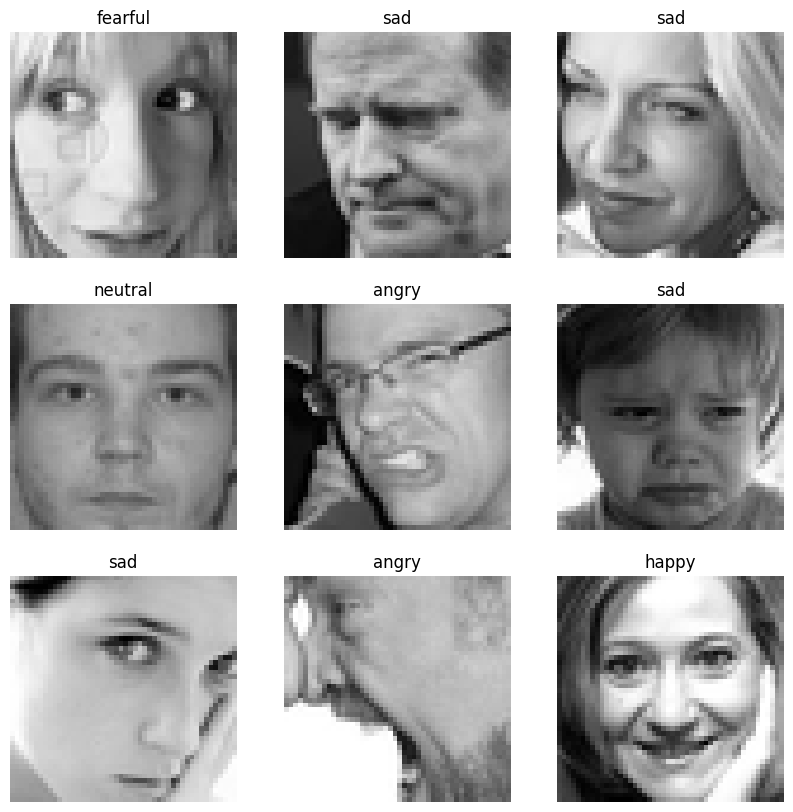

In [5]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Model Training



In [10]:
normalization_layer = tf.keras.layers.Rescaling(1./255)   #normalization layer to put in model. Make alter range of values to [0,1].

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 7

model = tf.keras.Sequential([
  normalization_layer,
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.Conv2D(128, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(256, 5, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Conv2D(512, 3, activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.25),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])


model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=30,
  callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         patience=7,
                                                         verbose= 1 ,
                                                         restore_best_weights=True
                                                        )]
)


Epoch 1/30
718/718 [==============================] - 23s 29ms/step - loss: 1.8709 - accuracy: 0.3219 - val_loss: 1.6158 - val_accuracy: 0.3640
Epoch 2/30
718/718 [==============================] - 20s 28ms/step - loss: 1.4229 - accuracy: 0.4454 - val_loss: 1.4260 - val_accuracy: 0.4499
Epoch 3/30
718/718 [==============================] - 20s 28ms/step - loss: 1.2676 - accuracy: 0.5131 - val_loss: 1.6422 - val_accuracy: 0.4271
Epoch 4/30
718/718 [==============================] - 21s 29ms/step - loss: 1.1681 - accuracy: 0.5549 - val_loss: 1.3111 - val_accuracy: 0.5081
Epoch 5/30
718/718 [==============================] - 20s 28ms/step - loss: 1.0849 - accuracy: 0.5872 - val_loss: 1.2149 - val_accuracy: 0.5449
Epoch 6/30
718/718 [==============================] - 20s 28ms/step - loss: 0.9999 - accuracy: 0.6207 - val_loss: 1.3559 - val_accuracy: 0.5008
Epoch 7/30
718/718 [==============================] - 22s 31ms/step - loss: 0.9131 - accuracy: 0.6535 - val_loss: 1.2715 - val_accuracy: